In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os.path
import os.path as osp
from codex import io as codex_io
from codex import config as codex_config
from codex.ops import cytometry
from skimage import exposure
from codex.function import data as function_data

In [2]:
import skimage.io as skio

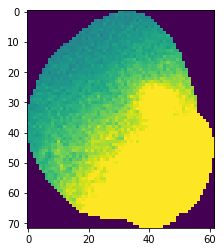

In [4]:
from scipy.stats import describe
img = skio.imread('/lab/data/cellimages/00086_cell_extract.png')
plt.imshow(img)

In [5]:
describe(img.ravel())

DescribeResult(nobs=4464, minmax=(0, 255), mean=149.72043010752688, variance=10062.51962733009, skewness=-0.5126904025926321, kurtosis=-1.2718138753921178)

In [14]:
describe(filters.gaussian(img, sigma=1, preserve_range=True).ravel())

DescribeResult(nobs=4464, minmax=(0.0, 255.0), mean=149.64874025546527, variance=9156.802520134072, skewness=-0.4828603041425399, kurtosis=-1.2187164766498926)

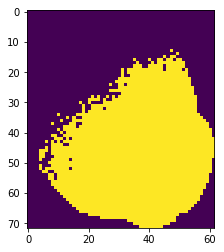

In [17]:
from skimage import filters
plt.imshow(img > 175)

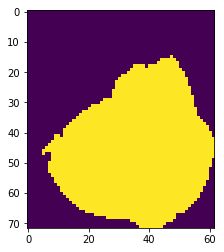

In [20]:
from skimage import filters
plt.imshow(filters.gaussian(img, sigma=1, preserve_range=True) > 175)

In [2]:
exp_name = '20180830-D33-US-LABELED-9BY9'
exp_out_dir = osp.join(os.environ['CODEX_DATA_DIR'], 'dna-stain', exp_name, 'output', 'v01')
exp_conf_dir = osp.join(os.environ['CODEX_ANALYSIS_REPO_DIR'], 'config', 'experiment', 'dna-stain', exp_name)
nuc_cyc = 0
nuc_ch = 0
tx, ty = 5, 5
tile_file = codex_io.get_processor_img_path(ireg=0, tx=tx, ty=ty)
tile_file

'processor/tile/R001_X006_Y006.tif'

In [3]:
best_z = function_data.get_best_focus_data(exp_out_dir).set_index(['tile_x', 'tile_y']).loc[(tx, ty)]['best_z']
best_z

13

In [4]:
exp_conf = codex_config.load(exp_conf_dir)
tile = codex_io.read_tile(osp.join(exp_out_dir, tile_file))

if tile.dtype == np.uint16:
    tile = exposure.rescale_intensity(tile, in_range=np.uint16, out_range=np.uint8).astype(np.uint8)

tile.shape, tile.dtype

((1, 22, 3, 1008, 1344), dtype('uint8'))

In [5]:
img_nuc = tile[nuc_cyc, best_z, nuc_ch]
img_nuc.shape

(1008, 1344)

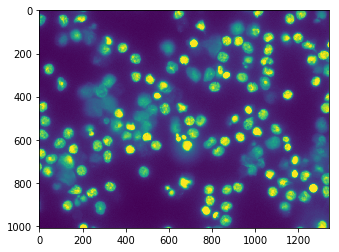

In [6]:
plt.imshow(img_nuc)

In [7]:
# exp_conf = codex_config.load(exp_conf_dir)
# exp_conf._conf['processor']['cytometry']['quantification_params'] = dict(
#         include_nucleus_intensity=True,
#         include_cell_graph=True,
#         spot_count_channels=['Plasmid'],
#         spot_count_params=dict(circularity_range=[.5, 1], area_range=[2, 64])
#     )
exp_conf._conf['processor']['cytometry']

{'membrane_channel_name': 'PHA',
 'nuclei_channel_name': 'DAPI',
 'quantification_params': {'include_cell_graph': True,
  'include_nucleus_intensity': True,
  'spot_count_channels': ['Plasmid'],
  'spot_count_params': {'area_range': [8, 256],
   'circularity_range': [0.9, 1],
   'threshold': 175}},
 'segmentation_params': {'membrane_gamma': 0.1,
  'membrane_sigma': 5,
  'min_size': 12,
  'nucleus_dilation': 6},
 'target_shape': [504, 672]}

In [8]:
op = cytometry.Cytometry2D(exp_conf)

In [9]:
op.initialize()

Using TensorFlow backend.


In [10]:
img_label, stats = op.run(tile, best_focus_z_plane=best_z)

/usr/local/lib/python3.5/dist-packages/skimage/io/_io.py:140: UserWarning: /lab/data/cellimages/00009_cell_threshold_ct1.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/lib/python3.5/dist-packages/skimage/io/_io.py:140: UserWarning: /lab/data/cellimages/00012_cell_threshold_ct1.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/lib/python3.5/dist-packages/skimage/io/_io.py:140: UserWarning: /lab/data/cellimages/00012_nucleus_threshold_ct1.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/lib/python3.5/dist-packages/skimage/io/_io.py:140: UserWarning: /lab/data/cellimages/00035_cell_threshold_ct2.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/lib/python3.5/dist-packages/skimage/io/_io.py:140: UserWarning: /lab/data/cellimages/00035_nucleus_threshold_ct1.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/lib/python3.5

In [11]:
stats.head()

,id,x,y,z,cell_size,cell_diameter,cell_perimeter,cell_solidity,nucleus_size,nucleus_diameter,...,ci:Plasmid,ni:DAPI,ni:PHA,ni:Plasmid,n_neighbors,neighbor_ids,adj_neighbor_pct,adj_bg_pct,cs:Plasmid,ns:Plasmid
0,1,216.220355,6.979458,13,152.577298,13.937986,176.870058,0.970988,18.662583,4.874622,...,39.972923,139.259542,89.282443,45.900763,1,9,73.22,26.78,0,0
1,2,1005.164669,22.410370,13,546.770934,26.385041,280.468037,0.908833,125.936818,12.662849,...,65.104482,218.434389,201.657240,46.364253,2,"12,14","5.12,40.47",54.42,2,0
2,3,1215.365273,25.301929,13,443.058261,23.751196,229.095454,0.952527,211.841683,16.423313,...,31.540514,194.909886,106.659718,36.792872,1,6,32.69,67.31,0,0
3,4,1311.819876,19.869048,13,275.237479,18.720129,165.882251,0.982706,178.647929,15.081830,...,78.257764,107.655502,37.657895,75.693780,1,10,12.99,87.01,0,0
4,5,645.793537,26.768380,13,656.894419,28.920303,274.610173,0.976907,193.321563,15.688998,...,102.915637,198.622697,157.017686,79.867354,0,,,100.00,0,0


In [12]:
stats.groupby(['cs:Plasmid', 'ns:Plasmid']).size().unstack()

ns:Plasmid,0,1,2,4
cs:Plasmid,,,,
0,136.0,5.0,NaN,NaN
1,24.0,8.0,NaN,NaN
2,3.0,2.0,NaN,NaN
3,1.0,NaN,1.0,1.0


In [13]:
img_label.shape

(2, 22, 2, 1008, 1344)

In [14]:
img_label.max()

87

In [15]:
img_bound = img_label[1, best_z, 1].clip(0, 1)

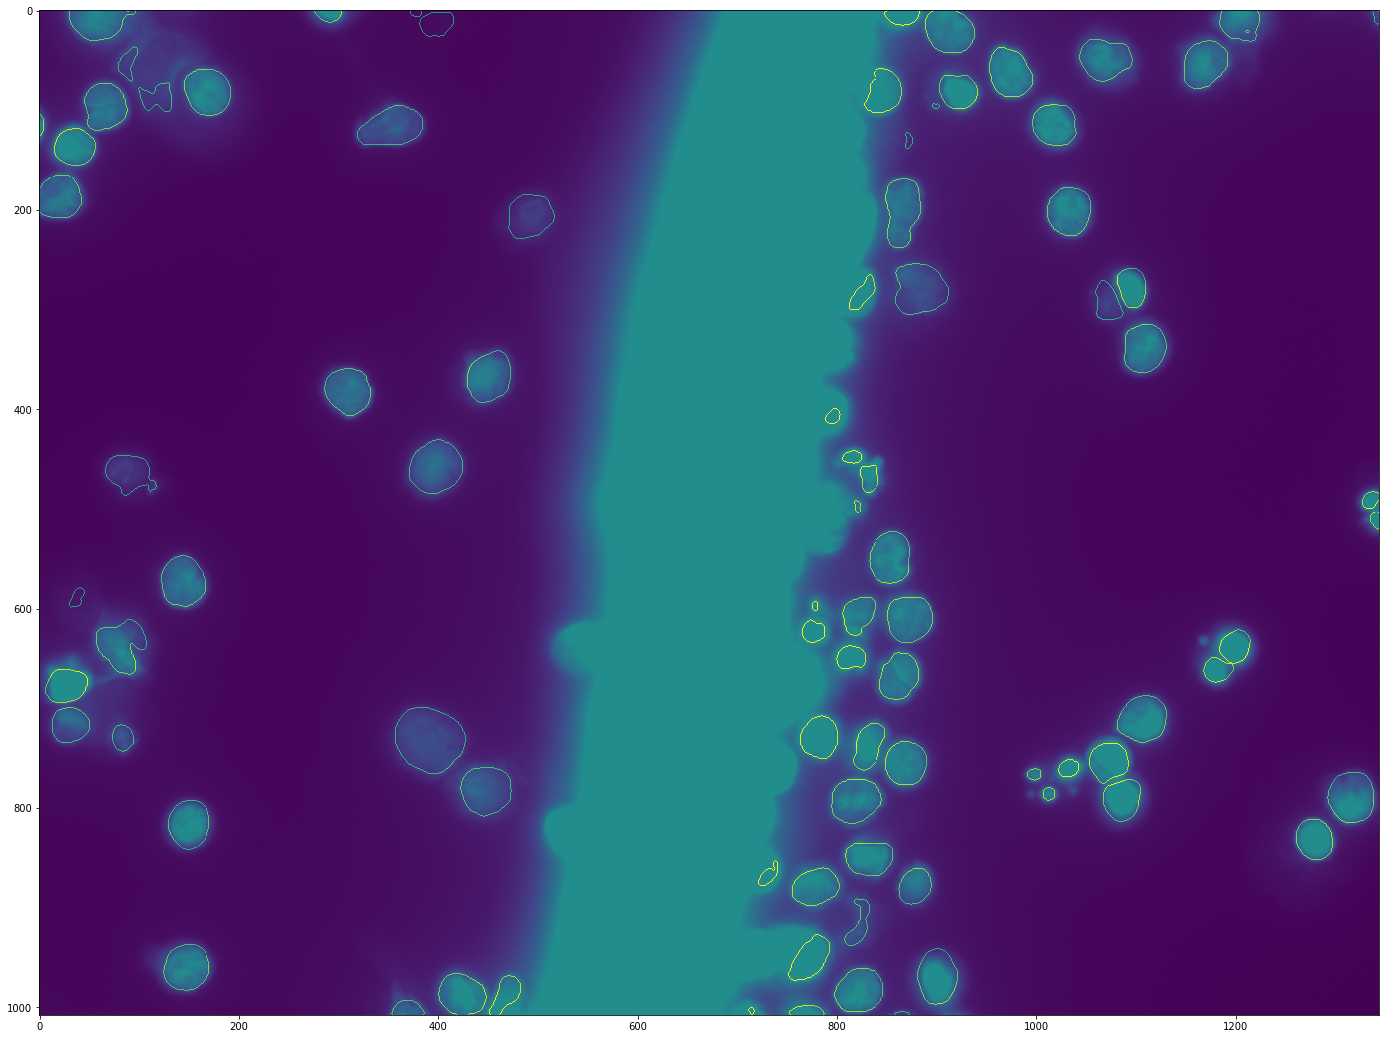

In [16]:
from skimage import segmentation
plt.imshow(.5*img_bound.astype(np.uint8) * 255 + .5*img_nuc)
plt.gcf().set_size_inches(24, 24)